In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jaxley as jx
from jaxley import Compartment

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.lk04 import Hyper, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak
from jaxley_mech.utils import prettify



In [2]:
META = {
    "cell_type": "rod",
    "species": "Larval tiger salamanders (Ambystoma tigrinum)",
    "reference": "Liu, X.-D., & Kourennyi, D. E. (2004). Effects of Tetraethylammonium on Kx Channels and Simulated Light Response in Rod Photoreceptorss. Annals of Biomedical Engineering, 32(10), 1428–1442. https://doi.org/10.1114/B:ABME.0000042230.99614.8d",
    "code": "https://modeldb.science/64228",
}

Liu & Kourennyi (2004) implemented the ion channels in the inner segment of the photoreceptors.

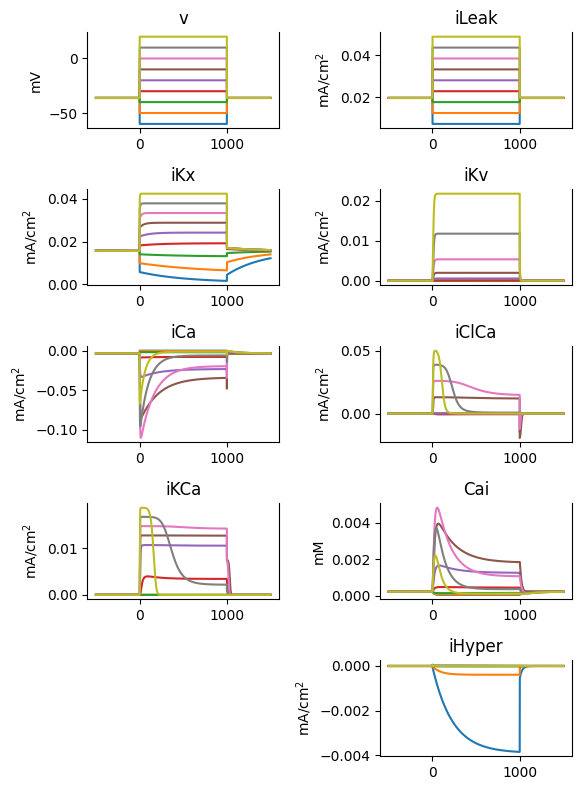

In [3]:

params = {
    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.332e-3, # The photoreceptor will not oscillate
                        # if KCa_Khalf is lower than 0.33.
    "Ca_gCa": 4e-3,
    "eCa": 40,
    
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,
    "eK": -74,

    "Hyper_gHyper": 2.5e-3,
    "Hyper_eHyper": -32,

    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,
}


to_records = ["v", "Cai", "iCa", "iClCa", "iKCa", "iLeak", "iHyper", 'iKv', 'iKx']
mosaic = [["v", "iLeak"], ["iKx", 'iKv'], ["iCa", "iClCa"], ["iKCa", "Cai"], ['.', 'iHyper']]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 8))

v_steps = jnp.arange(-60, 21, 10)
for v_step in v_steps:

    cell = Compartment()

    cell.insert(Kx())
    cell.insert(Kv())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    # cell.insert(CaNernstReversal())
    # The original code didn't allow eCa to be updated 
    cell.insert(Hyper())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 1000  # ms
    total_time = 3000 # ms
    dt = 0.1 # ms
    time_steps = int(total_time // dt + 1)
    time = jnp.linspace(0, total_time, time_steps)

    v = jnp.zeros(time_steps) - 36.2
    vc_on_start = int(pre_vc_time / dt)
    vc_on_end = int((pre_vc_time + vc_on_time) / dt)
    v = v.at[vc_on_start:vc_on_end].set(v_step)
    padding = int(500/dt)

    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):
        ax[rec].plot((s["time"]-pre_vc_time)[vc_on_start-padding:vc_on_end+padding], s[rec][vc_on_start-padding:vc_on_end+padding])
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)

        if rec == "v":
            ax[rec].set_ylabel("mV")
        elif rec == 'Cai':
            ax[rec].set_ylabel('mM')
        else:
            ax[rec].set_ylabel("mA/cm$^2$")

fig.tight_layout()

## Photocurrent

For now and for the purpose of keeping consistent with the paper, the dark current is approximated by injecting a constant current into the cell. Here, we use a precomputed bright photocurrent generated from the NEURON code provided by the authors. 

Text(0, 0.5, '$nA$')

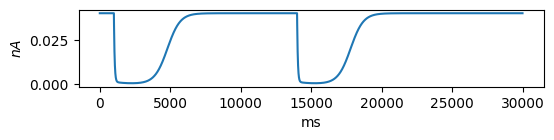

In [4]:
dt = 1
photocurrent = jnp.load("data/photocurrent.npy")
time_vec = jnp.arange(0, len(photocurrent), dt)
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(time_vec, photocurrent)
ax.set_xlabel("ms")
ax.set_ylabel(r"$nA$")


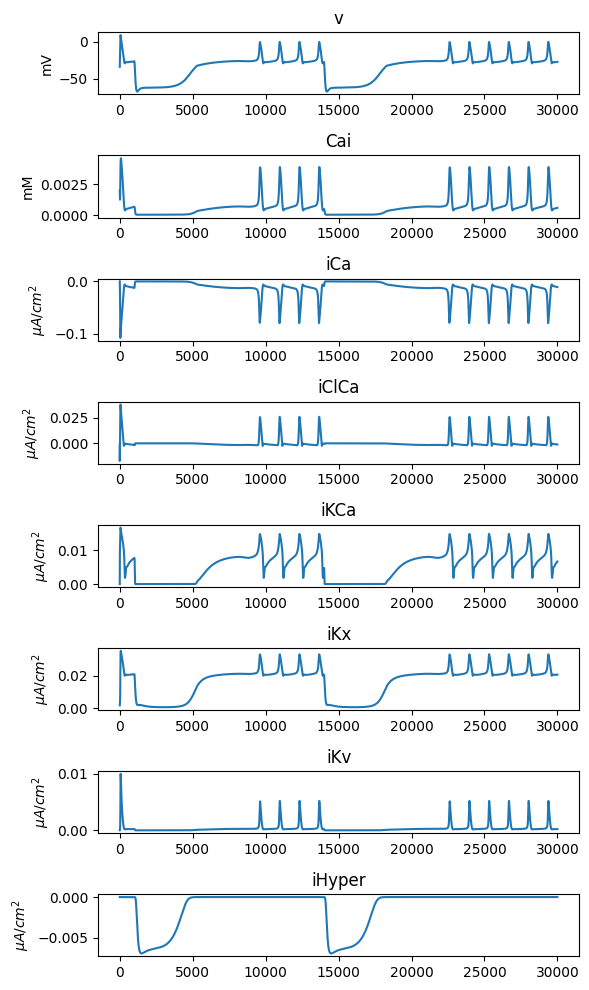

In [5]:
# TEA-induced oscillations in the rod photoreceptor

cell = Compartment()

cell.insert(Hyper())
cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
# cell.insert(CaNernstReversal())
cell.insert(Leak())

params = {
    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.33e-3,

    "Ca_gCa": 4e-3,
    "eCa": 40,
    
    "Hyper_gHyper": 2.5e-3,
    "Hyper_eHyper": -32,
}

for name, param in params.items():
    cell.set(name, param)

to_records = ["v", "Cai", "iCa", "iClCa", "iKCa", "iKx", "iKv", "iHyper",]

cell.stimulate(photocurrent, verbose=False)
for rec in to_records:
    cell.record(rec, verbose=False)

s = jx.integrate(cell, delta_t=dt)
s = prettify(s, to_records, dt)

mosaic = [[rec] for rec in to_records]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 10))
for i, rec in enumerate(to_records):
    ax[rec].plot(s["time"], s[rec])
    ax[rec].set_title(rec)

    if rec == "v":
        ax[rec].set_ylabel("mV")
    elif rec == "Cai":
        ax[rec].set_ylabel("mM")
    else:
        ax[rec].set_ylabel(r"$μA/cm^2$")

fig.tight_layout()


The NEURON model doesn't allow the reversal potential of the Calcium channel changes according to the intracellular calcium concentration. If we let it change, we can achieve similar results using half of the maximum calcium conductance.

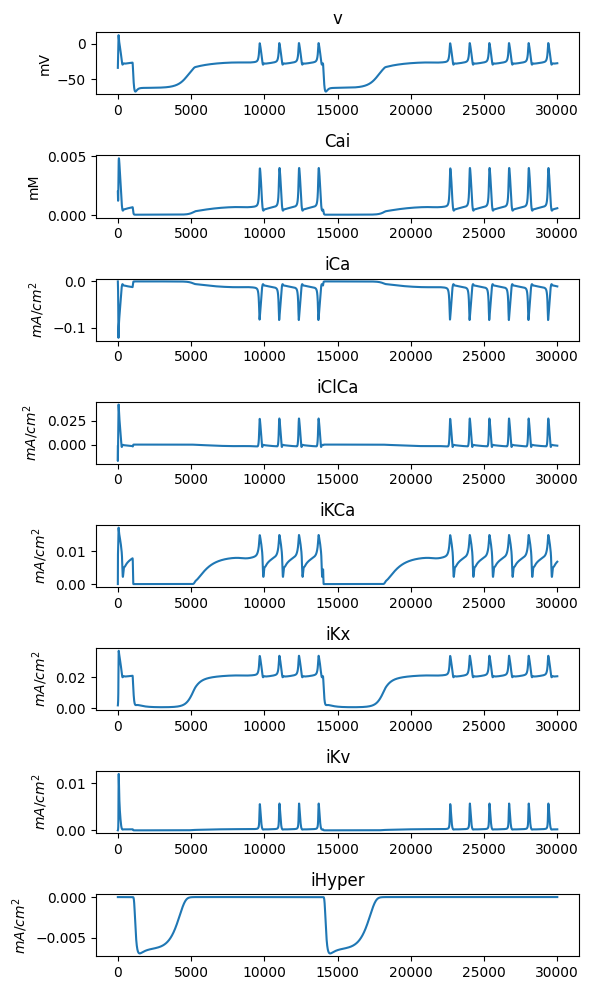

In [6]:
cell = Compartment()

cell.insert(Hyper())
cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
cell.insert(CaNernstReversal()) # allow eCa to be updated
cell.insert(Leak())

params = {
    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3,

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3, # changed from 0.33e-3

    "Ca_gCa": 2.2e-3, # changed from 4e-3
    "eCa": 40,
    
    "Hyper_gHyper": 2.5e-3,
    "Hyper_eHyper": -32,
}

for name, param in params.items():
    cell.set(name, param)

to_records = ["v", "Cai", "iCa", "iClCa", "iKCa", "iKx", "iKv", "iHyper"]

cell.stimulate(photocurrent, verbose=False)
for rec in to_records:
    cell.record(rec, verbose=False)

s = jx.integrate(cell, delta_t=dt)

mosaic = [[rec] for rec in to_records]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 10))
for i, rec in enumerate(to_records):
    ax[rec].plot(time_vec, s[i].T[:-1])
    ax[rec].set_title(rec)

    if rec == "v":
        ax[rec].set_ylabel("mV")
    elif rec == "Cai":
        ax[rec].set_ylabel("mM")
    else:
        ax[rec].set_ylabel(r"$mA/cm^2$")

fig.tight_layout()


### Combinding with Phototransduction model

In [7]:
from jaxley_mech.channels.kwu09 import Phototransduction

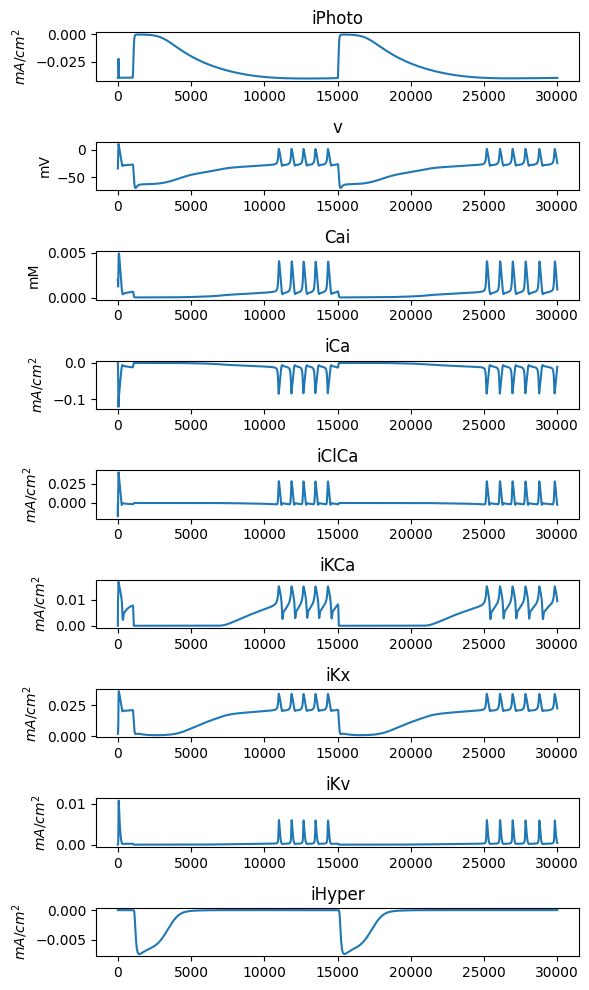

In [8]:
cell = Compartment()

cell.insert(Hyper())
cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
cell.insert(CaNernstReversal()) # allow eCa to be updated
cell.insert(Phototransduction(solver='newton'))
cell.insert(Leak())

params = {
    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3,

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3, # changed from 0.33e-3

    "Ca_gCa": 2.2e-3, # changed from 4e-3
    "eCa": 40,
    
    "Hyper_gHyper": 2.5e-3,
    "Hyper_eHyper": -32,
}

for name, param in params.items():
    cell.set(name, param)

to_records = ["iPhoto", "v", "Cai", "iCa", "iClCa", "iKCa", "iKx", "iKv", "iHyper"]


# light stimuli: 2 flashes of 20 ms light
pre_light_time_1 = 1000  # ms
pre_light_time_2 = 15000 # ms
light_on_time = 20  # ms
total_time = 30000 # ms
dt = 0.5 # ms
time_steps = int(total_time // dt + 1)

Jhv = jnp.zeros(time_steps)
light_on_start_1 = int(pre_light_time_1 / dt)
light_on_end_1 = int((pre_light_time_1 + light_on_time) / dt)
light_on_start_2 = int( pre_light_time_2 / dt)
light_on_end_2 = int((pre_light_time_2 + light_on_time) / dt)

intensity = 100
Jhv = Jhv.at[light_on_start_1:light_on_end_1].set(intensity)
Jhv = Jhv.at[light_on_start_2:light_on_end_2].set(intensity)

for rec in to_records:
    cell.record(rec, verbose=False)

cell.clamp("Phototransduction_Jhv", Jhv, verbose=False)

s = jx.integrate(cell, delta_t=dt, t_max=total_time)
s = prettify(s, to_records, dt)

mosaic = [[rec] for rec in to_records]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 10))
for i, rec in enumerate(to_records):
    ax[rec].plot(s["time"], s[rec])
    ax[rec].set_title(rec)

    if rec == "v":
        ax[rec].set_ylabel("mV")
    elif rec == "Cai":
        ax[rec].set_ylabel("mM")
    else:
        ax[rec].set_ylabel(r"$mA/cm^2$")

fig.tight_layout()


In [9]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-10-23 22:02:21CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.2.1

jax       : 0.4.35
jaxley    : 0.4.0
matplotlib: 3.9.2

Watermark: 2.4.3

